In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Create the local directory
!mkdir -p /content/dataset

# 2. Extract the .tgz file into that folder
# -x: extract | -z: gzip | -f: file | -C: destination directory
!tar -xzf "/content/drive/MyDrive/FinalYearProject/Dataset/MultiModalDataset.tgz" -C /content/dataset

In [3]:
# Install the library
!pip install demoji

import demoji
import re

# Download the latest emoji descriptions database
demoji.download_codes()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.9 MB/s eta 0:00:00


/tmp/ipython-input-886243763.py:8: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [4]:
def clean_tweet_v2(text):
    if not text:
        return ""

    # 1. Emoji Preservation: Convert 😭 to " :loudly_crying_face: "
    # We use separators to ensure the description is treated as distinct words
    text = demoji.replace_with_desc(text, sep=" ")

    # 2. URL Removal: Strip out web links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 3. HTML Artifacts: Remove things like &amp; or &lt;
    text = re.sub(r'&\w+;', '', text)

    # 4. Whitespace & Line Breaks: Flatten the tweet into one clean line
    text = re.sub(r'\s+', ' ', text).strip()

    # 5. Normalization: Lowercase everything
    return text.lower()

In [5]:
test_tweets = [
    "I feel so alone today... 😭 @mentalhealth_bot help me! http://support.com/help",
    "Feeling GREAT! 🌟 check this out at www.website.com #happy",
    "Why is everything so hard? &amp; I can't sleep. @user123 @user456",
    "Standard text with no noise."
]

print("--- PREPROCESSING TEST RESULTS ---\n")
for raw in test_tweets:
    cleaned = clean_tweet_v2(raw)
    print(f"RAW: {raw}")
    print(f"CLEANED: {cleaned}")
    print("-" * 30)

--- PREPROCESSING TEST RESULTS ---

RAW: I feel so alone today... 😭 @mentalhealth_bot help me! http://support.com/help
CLEANED: i feel so alone today... loudly crying face @mentalhealth_bot help me!
------------------------------
RAW: Feeling GREAT! 🌟 check this out at www.website.com #happy
CLEANED: feeling great! glowing star check this out at #happy
------------------------------
RAW: Why is everything so hard? &amp; I can't sleep. @user123 @user456
CLEANED: why is everything so hard? i can't sleep. @user123 @user456
------------------------------
RAW: Standard text with no noise.
CLEANED: standard text with no noise.
------------------------------


In [6]:
!pip install vaderSentiment

import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 6.4 MB/s eta 0:00:00


In [7]:
# -----------------------------
# Psycholinguistic Resources
# -----------------------------
FIRST_PERSON_SINGULAR = {
    "i", "me", "my", "mine", "i'm", "i’ve", "i'll", "i’d"
}

FIRST_PERSON_PLURAL = {
    "we", "us", "our", "ours", "we're", "we’ve", "we'll", "we’d"
}

sentiment_analyzer = SentimentIntensityAnalyzer()


def extract_psycholinguistic_features(user_path, max_tweets=50):
    timeline_path = os.path.join(user_path, "timeline.txt")
    if not os.path.exists(timeline_path):
        return None

    sentiments = []
    total_words = 0
    fps_count = 0
    fpp_count = 0
    mention_count = 0
    unique_mentions = set()
    tweet_count = 0
    media_count = 0

    image_ids = {
        os.path.splitext(f)[0]
        for f in os.listdir(user_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    }

    with open(timeline_path, "r") as f:
        lines = f.readlines()[-max_tweets:]

    for line in lines:
        try:
            tweet = json.loads(line)
            text = tweet.get("text", "")
            tweet_id = str(tweet.get("id_str", tweet.get("id")))

            if not text:
                continue

            cleaned = clean_tweet_v2(text)
            tokens = cleaned.split()

            total_words += len(tokens)
            fps_count += sum(1 for t in tokens if t in FIRST_PERSON_SINGULAR)
            fpp_count += sum(1 for t in tokens if t in FIRST_PERSON_PLURAL)

            score = sentiment_analyzer.polarity_scores(cleaned)["compound"]
            sentiments.append(score)

            mentions = re.findall(r'@\w+', text)
            mention_count += len(mentions)
            unique_mentions.update(mentions)

            if tweet_id in image_ids:
                media_count += 1

            tweet_count += 1

        except:
            continue

    if tweet_count == 0 or total_words == 0:
        return None

    return [
        fps_count / total_words,                # Self-focus ratio
        fpp_count / total_words,                # Collective focus
        np.std(sentiments) if len(sentiments) > 1 else 0.0,  # Sentiment volatility
        media_count / tweet_count,              # Media-to-text ratio
        mention_count / tweet_count,            # Mention frequency
        len(unique_mentions)                    # Social circle size
    ]


In [8]:
import glob
import tqdm
import json
import pandas as pd
import os

# 1. Update the path to match where we unzipped the data
DATA_PATH = "/content/dataset/MultiModalDataset"

# 2. Get the list of user folders
# Based on your path, it looks like: /content/dataset/positive/ and /content/dataset/negative/
positive_users = sorted(glob.glob(f"{DATA_PATH}/positive/*"))
negative_users = sorted(glob.glob(f"{DATA_PATH}/negative/*"))

user_dates = {}

print(f"Found {len(positive_users)} positive users and {len(negative_users)} negative users.")

# 3. Process the files
for user_path in tqdm.tqdm(positive_users + negative_users):
    file_path = f"{user_path}/timeline.txt"

    # Safety check: ensure the file exists before reading
    if os.path.exists(file_path):
        # Read JSON Lines
        df = pd.read_json(file_path, lines=True)

        # Extract and convert timestamps
        user_id = user_path.split("/")[-1]
        user_dates[user_id] = [
            int(round(date.timestamp())) for date in df["created_at"].tolist()
        ]

# 4. Save the output
# We'll save it to the local Colab folder first.
# You can also change this to "/content/drive/MyDrive/twitter-dates.json" to keep it forever.
output_path = "/content/twitter-dates.json"
with open(output_path, "wt") as f:
    json.dump(user_dates, f)

print(f"Finished! File saved to {output_path}")

Found 1402 positive users and 1402 negative users.


100%|██████████| 2804/2804 [05:08<00:00,  9.09it/s]


Finished! File saved to /content/twitter-dates.json


In [9]:
import torch
import json
import numpy as np
import pandas as pd
from datetime import datetime

# Automatically detect the best available device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Runtime Device: {device}")

Current Runtime Device: cuda


In [10]:
import os
import json
import torch
import numpy as np
from datetime import datetime

def extract_behavioral_tensors(user_dates_path, dataset_path):
    """
    Extracts temporal + psycholinguistic behavioral features per user.

    Returns:
        user_vectors: dict { user_id : torch.Tensor(feature_dim) }
    """

    # ---------- Load posting timestamps ----------
    with open(user_dates_path, "r") as f:
        user_dates = json.load(f)

    user_vectors = {}

    # ---------- Iterate over users (LABEL-INDEPENDENT) ----------
    for user_id, timestamps in tqdm.tqdm(user_dates.items()):

        if not timestamps:
            continue

        # ---------- Temporal Features ----------
        dates = [datetime.fromtimestamp(ts) for ts in timestamps]
        hours = [d.hour for d in dates]

        # 1. Late night posting ratio (00–05)
        late_night_ratio = sum(1 for h in hours if 0 <= h <= 5) / len(hours)

        # 2. Posts per day
        unique_days = len(set(d.date() for d in dates))
        posts_per_day = len(hours) / unique_days if unique_days > 0 else 0.0

        # 3. Posting time variance
        time_variance = np.std(hours)

        temporal_features = [
            late_night_ratio,
            posts_per_day,
            time_variance
        ]

        # ---------- Find user folder (positive OR negative) ----------
        user_path = None
        for label in ["positive", "negative"]:
            candidate = os.path.join(dataset_path, label, user_id)
            if os.path.isdir(candidate):
                user_path = candidate
                break

        if user_path is None:
            continue

        # ---------- Psycholinguistic Features ----------
        psycho_features = extract_psycholinguistic_features(user_path)

        if psycho_features is None:
            continue

        # ---------- Combine Features ----------
        full_features = temporal_features + psycho_features

        user_vectors[user_id] = torch.tensor(
            full_features,
            dtype=torch.float32
        ).to(device)

    return user_vectors


# Run the extraction and move data to the correct device
behavioral_vectors = extract_behavioral_tensors("/content/twitter-dates.json","/content/dataset/MultiModalDataset")
print(f"Extracted behavioral vectors for {len(behavioral_vectors)} users.")

100%|██████████| 2803/2803 [03:08<00:00, 14.89it/s]

Extracted behavioral vectors for 2803 users.


In [11]:
behavioral_vectors

{'0mfg_is_tht_J3T': tensor([3.2787e-01, 2.7727e+00, 7.7196e+00, 1.0943e-01, 1.8868e-03, 5.0886e-01,
         4.2000e-01, 3.2000e-01, 1.5000e+01], device='cuda:0'),
 '123BastardzInc': tensor([0.0309, 3.3448, 5.2940, 0.0230, 0.0069, 0.4630, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 '1D_w_Polsce': tensor([1.1972e-01, 3.0429e+01, 4.0254e+00, 2.6786e-02, 2.5510e-03, 4.9573e-01,
         2.0000e-01, 7.6000e-01, 3.4000e+01], device='cuda:0'),
 '1DirectionNips': tensor([2.6652e-01, 1.5133e+01, 6.6989e+00, 2.4320e-02, 2.8612e-03, 4.0890e-01,
         4.6000e-01, 1.0200e+00, 3.4000e+01], device='cuda:0'),
 '1KirstyAnn': tensor([7.1429e-02, 4.2609e+00, 5.6258e+00, 4.7194e-02, 3.8265e-03, 3.9984e-01,
         1.2000e-01, 1.0800e+00, 2.7000e+01], device='cuda:0'),
 '1in5Comms': tensor([2.8650e-01, 1.2964e+01, 7.7865e+00, 0.0000e+00, 3.5971e-03, 4.0266e-01,
         0.0000e+00, 1.6000e-01, 8.0000e+00], device='cuda:0'),
 '1ladysthoughts': tensor([0.4000, 2.1429, 8.0554, 0.1232, 0.0000, 0.5

In [12]:
import json
import torch
from datetime import datetime

# 1. Load the original JSON data
with open("/content/twitter-dates.json", "r") as f:
    raw_data = json.load(f)

# 2. Pick one user to inspect (from your output)
sample_user = '0mfg_is_tht_J3T'

if sample_user in raw_data and sample_user in behavioral_vectors:
    print(f"--- COMPARISON FOR USER: {sample_user} ---")

    # Show first 5 raw timestamps and their human-readable time
    raw_timestamps = raw_data[sample_user]
    print(f"\n[RAW DATA] Total Tweets: {len(raw_timestamps)}")
    print("First 5 Timestamps:", raw_timestamps[:5])

    readable_times = [datetime.fromtimestamp(ts).strftime('%H:%M:%S') for ts in raw_timestamps[:5]]
    print("First 5 Posting Times:", readable_times)

    # Show the resulting Tensor
    # .cpu() ensures it prints even if you were on a GPU
    vector = behavioral_vectors[sample_user].cpu()
    print(f"\n[PYTORCH TENSOR]: {vector}")
    print(f"Index 0 (Late Night Ratio): {vector[0].item():.4f}")
    print(f"Index 1 (Posts Per Day)   : {vector[1].item():.4f}")
    print(f"Index 2 (Time Variance)   : {vector[2].item():.4f}")
else:
    print("User not found in data.")

--- COMPARISON FOR USER: 0mfg_is_tht_J3T ---

[RAW DATA] Total Tweets: 61
First 5 Timestamps: [1450068630, 1450068219, 1450067724, 1450051104, 1450048195]
First 5 Posting Times: ['04:50:30', '04:43:39', '04:35:24', '23:58:24', '23:09:55']

[PYTORCH TENSOR]: tensor([3.2787e-01, 2.7727e+00, 7.7196e+00, 1.0943e-01, 1.8868e-03, 5.0886e-01,
        4.2000e-01, 3.2000e-01, 1.5000e+01])
Index 0 (Late Night Ratio): 0.3279
Index 1 (Posts Per Day)   : 2.7727
Index 2 (Time Variance)   : 7.7196


In [13]:
from google.colab import userdata
from transformers import AutoTokenizer, AutoModel
import torch
import os

# 1. Use the token from your Colab Secrets
try:
    hf_token = userdata.get('HF_TOKEN')
    print("HF Token found!")
except:
    print("Error: HF_TOKEN not found in Colab Secrets. Please add it first.")

# 2. Load the Gated Model (It will now work with the token)
model_name = "AIMH/mental-bert-base-cased"

print("Downloading MentalBERT... this might take a minute.")
tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
model = AutoModel.from_pretrained(model_name, token=hf_token).to(device) # using 'device' from your previous cell

model.eval()
print("MentalBERT loaded successfully!")

HF Token found!


tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at AIMH/mental-bert-base-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MentalBERT loaded successfully!


In [14]:
import os
import random
import json

# The base path we unzipped earlier
DATA_PATH = "/content/dataset/MultiModalDataset"

def inspect_random_sample():
    # 1. Randomly pick Category
    label = random.choice(['positive', 'negative'])
    label_path = os.path.join(DATA_PATH, label)

    # 2. Randomly pick User
    user_folders = [f for f in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, f))]
    random_user = random.choice(user_folders)
    user_path = os.path.join(label_path, random_user)

    # 3. Read Timeline and pick a random Tweet (document)
    timeline_file = os.path.join(user_path, "timeline.txt")
    random_tweet = "No tweets found."

    if os.path.exists(timeline_file):
        with open(timeline_file, 'r') as f:
            lines = f.readlines()
            if lines:
                # Pick a random line (one tweet) and parse it
                random_tweet = json.loads(random.choice(lines))

    # 4. Check for images
    images = [img for img in os.listdir(user_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

    # Display Results
    print(f"--- RANDOM DATA SAMPLE ---")
    print(f"LABEL:    {label.upper()}")
    print(f"USER ID:  {random_user}")
    print(f"IMAGES:   {len(images)} found (Examples: {images[:3]})\n")
    print(f"--- SAMPLED TWEET ---")
    if isinstance(random_tweet, dict):
        print(f"Date: {random_tweet.get('created_at')}")
        print(f"Text: {random_tweet.get('text')}")
    else:
        print(random_tweet)

# Execute the inspection
inspect_random_sample()

--- RANDOM DATA SAMPLE ---
LABEL:    NEGATIVE
USER ID:  Solemn_Jester
IMAGES:   0 found (Examples: [])

--- SAMPLED TWEET ---
Date: Mon Dec 26 01:06:47 +0000 2016
Text: RT @chucksteakpt: @asamjulian https://t.co/3BJHYVrnnY


In [15]:
import os
import random

# The path to your unzipped dataset
DATA_PATH = "/content/dataset/MultiModalDataset"

# 1. Pick a random category and user
label = random.choice(['positive', 'negative'])
user_list = os.listdir(os.path.join(DATA_PATH, label))
random_user = random.choice(user_list)
user_path = os.path.join(DATA_PATH, label, random_user)

# 2. Open the timeline and grab one random raw line (JSON string)
timeline_path = os.path.join(user_path, "timeline.txt")

if os.path.exists(timeline_path):
    with open(timeline_path, 'r') as f:
        lines = f.readlines()
        if lines:
            raw_doc = random.choice(lines)
            print(f"--- RAW DATA FROM USER: {random_user} ({label}) ---\n")
            print(raw_doc)
        else:
            print("Timeline file is empty.")
else:
    print(f"No timeline.txt found for user {random_user}")

--- RAW DATA FROM USER: Kakai23438683 (negative) ---

{"created_at":"Tue Dec 13 13:09:56 +0000 2016","id":808660225494421504,"id_str":"808660225494421504","text":"Mga muyak na lipad ng lipad. #YbraMihanItsComplicated https://t.co/auXt3VLMdl","truncated":false,"entities":{"hashtags":[{"text":"YbraMihanItsComplicated","indices":[29,53]}],"symbols":[],"user_mentions":[],"urls":[{"url":"https://t.co/auXt3VLMdl","expanded_url":"https://twitter.com/patronusfairy/status/808659724287623169","display_url":"twitter.com/patronusfairy/…","indices":[54,77]}]},"source":"<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>","in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":751627013446701056,"id_str":"751627013446701056","name":"😊😊😊","screen_name":"Kakai23438683","location":"","description":"Introvert.books.music.nature.PHL ❤️❤️","url":null,"entities":{"d

In [16]:
import os
import random
import json
from IPython.display import display, Image

# Base path for your dataset
DATA_PATH = "/content/dataset/MultiModalDataset"

def display_raw_tweet_and_image():
    # 1. Select a random category and user
    label = random.choice(['positive', 'negative'])
    label_path = os.path.join(DATA_PATH, label)
    user_list = [u for u in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, u))]

    random_user = random.choice(user_list)
    user_path = os.path.join(label_path, random_user)

    # 2. Open timeline.txt and pick a random raw line
    timeline_path = os.path.join(user_path, "timeline.txt")

    if not os.path.exists(timeline_path):
        print(f"No timeline found for user {random_user}")
        return

    with open(timeline_path, 'r') as f:
        lines = f.readlines()
        if not lines:
            print("Timeline is empty.")
            return

        # Select the raw line
        raw_line = random.choice(lines)

        # Parse it ONLY to get the ID for the image check
        tweet_data = json.loads(raw_line)
        tweet_id = str(tweet_data.get('id'))

    # 3. Print the raw data header and the exact raw string
    print(f"--- RAW DATA FROM USER: {random_user} ({label}) ---\n")
    print(raw_line)

    # 4. Check for an image file named EXACTLY after the tweet ID
    found_image = None
    for ext in ['.jpg', '.jpeg', '.png']:
        potential_path = os.path.join(user_path, tweet_id + ext)
        if os.path.exists(potential_path):
            found_image = potential_path
            break

    # 5. Display the image or the 'no image' message
    if found_image:
        print(f"\nIMAGE FOUND: {os.path.basename(found_image)}")
        display(Image(filename=found_image, width=400))
    else:
        print(f"\nno image for this tweet (ID: {tweet_id})")
    return found_image

# Run the inspector
display_raw_tweet_and_image()

--- RAW DATA FROM USER: stephenralp08 (negative) ---

{"created_at":"Thu Jan 12 08:13:06 +0000 2017","id":819457160795029504,"id_str":"819457160795029504","text":"Follower - 1, Unfollower - 1. I didn't know it'd be this simple. Get your weekly stats via https://t.co/dyjEOADvKV.","truncated":false,"entities":{"hashtags":[],"symbols":[],"user_mentions":[],"urls":[{"url":"https://t.co/dyjEOADvKV","expanded_url":"http://www.crowdfireapp.com/?r=tw","display_url":"crowdfireapp.com/?r=tw","indices":[91,114]}]},"source":"<a href=\"http://www.crowdfireapp.com\" rel=\"nofollow\">Crowdfire App</a>","in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":630435909,"id_str":"630435909","name":"stephen Javier","screen_name":"stephenralp08","location":"dubai","description":"","url":"http://t.co/SnfSDa4Cfk","entities":{"url":{"urls":[{"url":"http://t.co/SnfSDa4Cfk","expanded_url":"http://www.you

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

--- RAW DATA FROM USER: sarinedion (positive) ---

{"created_at":"Thu Sep 11 05:13:44 +0000 2014","id":509932785922887680,"id_str":"509932785922887680","text":"♫Ever as before, ever just as sure as the sun will rise♫","truncated":false,"entities":{"hashtags":[],"symbols":[],"user_mentions":[],"urls":[]},"source":"<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>","in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":36443618,"id_str":"36443618","name":"♕Princess♕","screen_name":"sarinedion","location":"California Gurl! ","description":"Not Evil dear. Wicked! And you're gonna hear me Roar! True love is the most powerful magic of all. It creates happiness ✨ #mypretties #katycat #oncer","url":"https://t.co/gbiECtOByy","entities":{"url":{"urls":[{"url":"https://t.co/gbiECtOByy","expanded_url":"http://sarenabeana.tumblr.com","display_url":"sarenabeana.tumblr.com

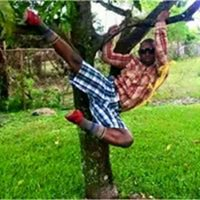

In [17]:
while not display_raw_tweet_and_image():
  print('--------------next------------')

In [18]:
import os
import json
import torch
import tqdm

# This will store our granular data: { 'tweet_id': { 'embedding': tensor, 'user_id': str, 'label': str } }
paired_text_data = {}

def extract_granular_text_features():
    all_users = positive_users + negative_users
    print(f"Searching for Tweet+Image pairs among {len(all_users)} users...")

    for user_path in tqdm.tqdm(all_users):
        user_id = os.path.basename(user_path)
        label = 'positive' if 'positive' in user_path else 'negative'
        timeline_path = os.path.join(user_path, "timeline.txt")

        # Get list of image filenames (without extensions) for fast lookup
        image_ids = {os.path.splitext(f)[0] for f in os.listdir(user_path)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))}

        if not os.path.exists(timeline_path) or not image_ids:
            continue

        with open(timeline_path, 'r') as f:
            for line in f:
                try:
                    tweet = json.loads(line)
                    tweet_id = str(tweet.get('id_str', tweet.get('id')))

                    # ONLY process if there is a matching image
                    if tweet_id in image_ids:
                        raw_text = tweet.get('text', '')
                        text = clean_tweet_v2(raw_text)
                        if not text: continue

                        # MentalBERT Extraction
                        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)

                        with torch.no_grad():
                            outputs = model(**inputs)
                            # Extract [CLS] token vector
                            embedding = outputs.last_hidden_state[0, 0, :].cpu()

                        # Store everything needed for the Fusion & SHAP phases
                        paired_text_data[tweet_id] = {
                            'embedding': embedding,
                            'user_id': user_id,
                            'label': label,
                            'raw_text': text # Saved for SHAP "Textual Highlights" later
                        }
                except: continue

    # Save progress to Drive
    save_path = "/content/drive/MyDrive/FinalYearProject/Dataset/granular_text_embeddings.pt"
    torch.save(paired_text_data, save_path)
    print(f"\nSaved {len(paired_text_data)} paired embeddings to {save_path}")

# Start the granular extraction
extract_granular_text_features()

Searching for Tweet+Image pairs among 2804 users...



100%|██████████| 2804/2804 [15:05<00:00,  3.10it/s]



Saved 85071 paired embeddings to /content/drive/MyDrive/FinalYearProject/Dataset/granular_text_embeddings.pt


In [19]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
import tqdm

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load Pre-trained EfficientNetV2-S
# We use 'weights' instead of 'pretrained=True' (modern PyTorch style)
base_model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Remove the final classification layer to get 1280-dimensional features
# We keep everything up to the 'avgpool' layer
model_visual = nn.Sequential(*list(base_model.children())[:-1])
model_visual = model_visual.to(device)
model_visual.eval()

# 3. Image Pre-processing Pipeline
# Standard transformations for EfficientNetV2
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Extraction Logic
visual_embeddings = {}

# We load the keys from the TEXT embeddings we just saved to ensure perfect alignment
text_data = torch.load("/content/drive/MyDrive/FinalYearProject/Dataset/granular_text_embeddings.pt")
tweet_ids_to_process = list(text_data.keys())

print(f"Starting Visual Extraction for {len(tweet_ids_to_process)} paired images...")

def get_image_path(user_id, label, tweet_id):
    # Helper to find the image file with any valid extension
    user_path = os.path.join(DATA_PATH, label, user_id)
    for ext in ['.jpg', '.jpeg', '.png']:
        path = os.path.join(user_path, tweet_id + ext)
        if os.path.exists(path):
            return path
    return None

for t_id in tqdm.tqdm(tweet_ids_to_process):
    info = text_data[t_id]
    img_path = get_image_path(info['user_id'], info['label'], t_id)

    if img_path:
        try:
            # Load and Transform
            img = Image.open(img_path).convert('RGB')
            img_t = transform(img).unsqueeze(0).to(device)

            # Extract Feature Vector
            with torch.no_grad():
                features = model_visual(img_t)
                # Flatten the [1, 1280, 1, 1] output to [1280]
                vector = torch.flatten(features, 1).cpu().squeeze()

            visual_embeddings[t_id] = vector
        except Exception as e:
            # Skip corrupted images
            continue

# 5. Save the Visual Embeddings
save_path = "/content/drive/MyDrive/FinalYearProject/Dataset/granular_visual_embeddings.pt"
torch.save(visual_embeddings, save_path)
print(f"\nSuccessfully extracted {len(visual_embeddings)} visual vectors!")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 129MB/s]


Starting Visual Extraction for 85071 paired images...


100%|██████████| 85071/85071 [37:41<00:00, 37.62it/s]



Successfully extracted 68798 visual vectors!


In [20]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Load all our pieces
print("Loading embeddings...")
text_data = torch.load("/content/drive/MyDrive/FinalYearProject/Dataset/granular_text_embeddings.pt")
visual_data = torch.load("/content/drive/MyDrive/FinalYearProject/Dataset/granular_visual_embeddings.pt")
# Load the behavioral vectors we made at the very beginning
# If you didn't save them to drive, ensure 'behavioral_vectors' is in memory
# behavioral_vectors = {...}

# 2. Find the intersection of IDs
common_ids = set(text_data.keys()).intersection(set(visual_data.keys()))
print(f"Found {len(common_ids)} perfectly aligned Tri-modal samples.")

X_text = []
X_visual = []
X_behavior = []
y = []
ids = []

for t_id in common_ids:
    # Text (768)
    X_text.append(text_data[t_id]['embedding'])

    # Visual (1280)
    X_visual.append(visual_data[t_id])

    # Behavior (3) - Linked via User ID
    u_id = text_data[t_id]['user_id']
    if u_id in behavioral_vectors:
        # Move tensor to CPU and convert to list if necessary
        X_behavior.append(behavioral_vectors[u_id].cpu())

        # Label (1 for positive, 0 for negative)
        label = 1 if text_data[t_id]['label'] == 'positive' else 0
        y.append(label)
        ids.append(t_id)

# 3. Convert to Tensors
X_text = torch.stack(X_text)
X_visual = torch.stack(X_visual)
X_behavior = torch.stack(X_behavior)
y = torch.tensor(y, dtype=torch.float32)

print(f"Final Shapes:")
print(f"Text: {X_text.shape}, Visual: {X_visual.shape}, Behavior: {X_behavior.shape}")

# 4. Split into Train (80%), Val (10%), and Test (10%)
# We use indices so we can keep track of which Tweet ID belongs to which split for SHAP later
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=42)

# Save the unified dataset to Drive
unified_data = {
    'train': (X_text[train_idx], X_visual[train_idx], X_behavior[train_idx], y[train_idx], [ids[i] for i in train_idx]),
    'val': (X_text[val_idx], X_visual[val_idx], X_behavior[val_idx], y[val_idx], [ids[i] for i in val_idx]),
    'test': (X_text[test_idx], X_visual[test_idx], X_behavior[test_idx], y[test_idx], [ids[i] for i in test_idx])
}

torch.save(unified_data, "/content/drive/MyDrive/FinalYearProject/Dataset/tri_modal_unified_data.pt")
print("Unified dataset saved! We are ready for the Fusion Model.")

Loading embeddings...
Found 68798 perfectly aligned Tri-modal samples.
Final Shapes:
Text: torch.Size([68798, 768]), Visual: torch.Size([68798, 1280]), Behavior: torch.Size([68798, 9])
Unified dataset saved! We are ready for the Fusion Model.


In [21]:
from torch.utils.data import Dataset, DataLoader

class TriModalDataset(Dataset):
    def __init__(self, text_tensors, visual_tensors, behavior_tensors, labels):
        self.text = text_tensors
        self.visual = visual_tensors
        self.behavior = behavior_tensors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.text[idx],
            self.visual[idx],
            self.behavior[idx],
            self.labels[idx]
        )

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TriModalDataset(*unified_data['train'][:4]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TriModalDataset(*unified_data['val'][:4]), batch_size=batch_size)
test_loader = DataLoader(TriModalDataset(*unified_data['test'][:4]), batch_size=batch_size)

In [22]:



# class RobustTriModalClassifier(nn.Module):
#     def __init__(self, text_dim=768, visual_dim=1280, behavior_dim=9):
#         super(RobustTriModalClassifier, self).__init__()

#         self.input_dim = text_dim + visual_dim + behavior_dim

#         # Fusion Head: A deep MLP designed for multi-modal interaction
#         self.network = nn.Sequential(
#             # First Hidden Layer: Consolidate the 2051 features
#             nn.Linear(self.input_dim, 1024),
#             nn.BatchNorm1d(1024), # Stabilizes the different modality scales
#             nn.ReLU(),
#             nn.Dropout(0.4),      # Stronger dropout for high-dimensional input

#             # Second Hidden Layer: Find cross-modal patterns
#             nn.Linear(1024, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),

#             # Third Hidden Layer: Refining features
#             nn.Linear(512, 128),
#             nn.ReLU(),

#             # Output Layer: Binary Classification
#             nn.Linear(128, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x_text, x_visual, x_behavior):
#         # Step 1: Concatenate (Early Fusion)
#         combined = torch.cat((x_text, x_visual, x_behavior), dim=1)

#         # Step 2: Forward pass through the decision network
#         return self.network(combined)

# # Initialize the 'Good' model
# model = RobustTriModalClassifier().to(device)

import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerGatedFusionClassifier(nn.Module):
    def __init__(self, text_dim=768, visual_dim=1280, behavior_dim=9, d_model=256, nhead=8):
        super(TransformerGatedFusionClassifier, self).__init__()

        # 1. Projection Layers: Map all modalities to the same d_model size
        self.text_proj = nn.Linear(text_dim, d_model)
        self.vis_proj = nn.Linear(visual_dim, d_model)
        self.beh_proj = nn.Linear(behavior_dim, d_model)

        # 2. Adaptive Gating Mechanism [cite: 118, 157]
        # This calculates a relevance score for each modality
        self.gate = nn.Sequential(
            nn.Linear(d_model * 3, 3),
            nn.Softmax(dim=1)
        )

        # 3. Transformer Encoder for Cross-Modal Attention [cite: 118, 264, 286]
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=512,
            batch_first=True,
            dropout=0.2
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # 4. Final Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_text, x_visual, x_behavior):
        # Project to common d_model space
        t_feat = self.text_proj(x_text)      # [Batch, 256]
        v_feat = self.vis_proj(x_visual)    # [Batch, 256]
        b_feat = self.beh_proj(x_behavior)  # [Batch, 256]

        # --- Gating Phase ---
        # Concatenate features to determine importance
        combined_static = torch.cat([t_feat, v_feat, b_feat], dim=1)
        gate_weights = self.gate(combined_static) # [Batch, 3]

        # Apply weights to modalities
        t_feat = t_feat * gate_weights[:, 0].unsqueeze(1)
        v_feat = v_feat * gate_weights[:, 1].unsqueeze(1)
        b_feat = b_feat * gate_weights[:, 2].unsqueeze(1)

        # --- Transformer Phase ---
        # Treat each modality as a "Token" in a sequence
        # Shape becomes [Batch, 3, 256]
        tokens = torch.stack([t_feat, v_feat, b_feat], dim=1)

        # Self-Attention allows Text to attend to Image and Behavior
        fused_tokens = self.transformer(tokens)

        # Use the mean of the tokens for classification
        fused_representation = fused_tokens.mean(dim=1)

        return self.classifier(fused_representation)

# Initialize the new Version 2 model
model = TransformerGatedFusionClassifier().to(device)
print(f"Version 2 Model (Transformer + Gated Fusion) initialized.")

print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters.")

Version 2 Model (Transformer + Gated Fusion) initialized.
Model initialized with 1,616,900 parameters.


In [23]:
import os

# Define the directory path
model_dir = '/content/drive/MyDrive/FinalYearProject/Models'

# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created directory: {model_dir}")
else:
    print(f"Directory already exists: {model_dir}")

Directory already exists: /content/drive/MyDrive/FinalYearProject/Models


In [24]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Configuration
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# Slows down learning rate if validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

num_epochs = 50
patience = 7  # For early stopping
best_val_loss = float('inf')
counter = 0

print("Starting Training...")

for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0.0
    for texts, visuals, behaviors, labels in train_loader:
        texts, visuals, behaviors, labels = texts.to(device), visuals.to(device), behaviors.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts, visuals, behaviors).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, visuals, behaviors, labels in val_loader:
            texts, visuals, behaviors, labels = texts.to(device), visuals.to(device), behaviors.to(device), labels.to(device)
            outputs = model(texts, visuals, behaviors).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate Accuracy
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.4f}")

    # Learning Rate Scheduler Step
    scheduler.step(avg_val_loss)

    # Early Stopping & Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/FinalYearProject/Models/best_trimodal_model_V4.pth')
        counter = 0
        print("--> Best model saved!")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered. Training finished.")
            break

Starting Training...
Epoch [1/50] | Train Loss: 0.3631 | Val Loss: 0.3172 | Val Acc: 0.8535
--> Best model saved!
Epoch [2/50] | Train Loss: 0.3165 | Val Loss: 0.3063 | Val Acc: 0.8590
--> Best model saved!
Epoch [3/50] | Train Loss: 0.2939 | Val Loss: 0.3072 | Val Acc: 0.8610
Epoch [4/50] | Train Loss: 0.2793 | Val Loss: 0.3069 | Val Acc: 0.8660
Epoch [5/50] | Train Loss: 0.2642 | Val Loss: 0.3064 | Val Acc: 0.8676
Epoch [6/50] | Train Loss: 0.2483 | Val Loss: 0.3119 | Val Acc: 0.8664
Epoch [7/50] | Train Loss: 0.2063 | Val Loss: 0.3099 | Val Acc: 0.8692
Epoch [8/50] | Train Loss: 0.1963 | Val Loss: 0.3162 | Val Acc: 0.8721
Epoch [9/50] | Train Loss: 0.1903 | Val Loss: 0.3240 | Val Acc: 0.8703
Early stopping triggered. Training finished.


Evaluating on Test Set...

      CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90      5006
    Positive       0.75      0.72      0.73      1874

    accuracy                           0.86      6880
   macro avg       0.82      0.81      0.82      6880
weighted avg       0.86      0.86      0.86      6880



<Figure size 800x600 with 0 Axes>

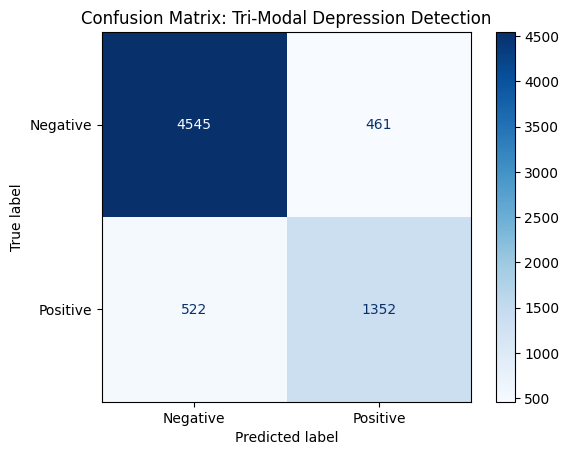

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_best_model():
    # 1. Load the best saved model weights
    model.load_state_dict(torch.load('/content/drive/MyDrive/FinalYearProject/Models/best_trimodal_model_V4.pth'))
    model.eval()

    y_true = []
    y_pred = []

    print("Evaluating on Test Set...")
    with torch.no_grad():
        for texts, visuals, behaviors, labels in test_loader:
            texts, visuals, behaviors, labels = texts.to(device), visuals.to(device), behaviors.to(device), labels.to(device)

            outputs = model(texts, visuals, behaviors).squeeze()
            predictions = (outputs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # 2. Print Classification Report
    print("\n" + "="*30)
    print("      CLASSIFICATION REPORT")
    print("="*30)
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

    # 3. Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix: Tri-Modal Depression Detection')
    plt.show()

# Run the evaluation
evaluate_best_model()

Calculating SHAP values using GradientExplainer (this may take a minute)...


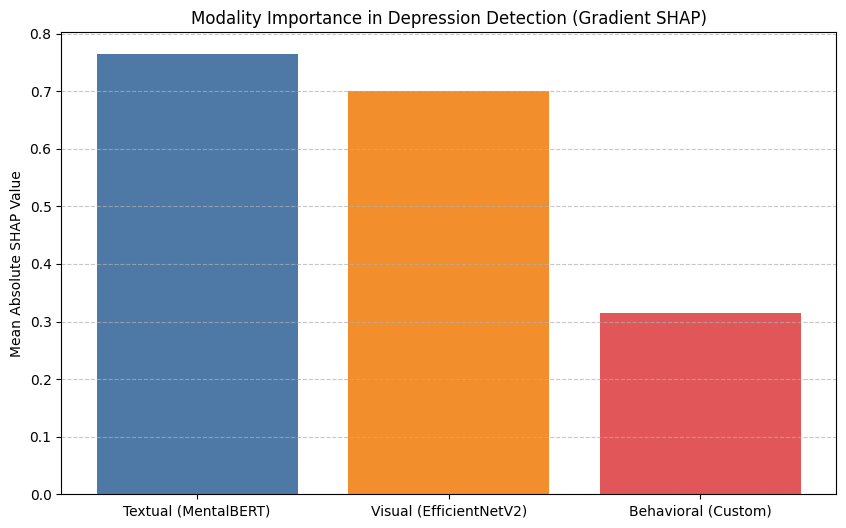

In [29]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare Background Data
# SHAP needs a 'background' to understand the 'baseline' distribution.
# We'll take 100 random samples from the training set. [cite: 108, 244]
train_text, train_vis, train_beh, _, _ = unified_data['train']
background_text = train_text[:100].to(device)
background_vis = train_vis[:100].to(device)
background_beh = train_beh[:100].to(device)

# 2. Define a Wrapper for SHAP
# This wrapper allows SHAP to process our three parallel data streams as a single unified tensor. [cite: 109, 205, 236]
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x_combined):
        # Correctly slice the 2051-dimensional fused vector back into original modalities [cite: 233, 236, 264]
        # Text: 768 | Visual: 1280 | Behavioral: 3 (or 9 in your updated version)
        # Note: If your behavior_dim is 9, update the indices accordingly (e.g., 2048:2057)
        t = x_combined[:, :768]
        v = x_combined[:, 768:2048]
        b = x_combined[:, 2048:]
        return self.model(t, v, b)

wrapped_model = ModelWrapper(model).to(device)
background_combined = torch.cat((background_text, background_vis, background_beh), dim=1)

# 3. Initialize the Gradient Explainer
# GradientExplainer is more stable for Transformers and complex gating mechanisms. [cite: 157, 268, 297]
explainer = shap.GradientExplainer(wrapped_model, background_combined)

# 4. Explain a Specific Sample
# We take the first 5 samples from the test set for a local explanation. [cite: 240, 270, 289]
test_text, test_vis, test_beh, test_labels, test_ids = unified_data['test']
test_samples_combined = torch.cat((test_text[:5], test_vis[:5], test_beh[:5]), dim=1).to(device)

print("Calculating SHAP values using GradientExplainer (this may take a minute)...")
# GradientExplainer returns attributions for each output; for binary classification, we take the first. [cite: 265, 287]
shap_values_list = explainer.shap_values(test_samples_combined)
shap_values = shap_values_list[0] if isinstance(shap_values_list, list) else shap_values_list

# 5. Visualize Modality Importance
# This generates the "Behavioral Feature Importance" and overall modality impact. [cite: 226, 241, 273]
shap_summary = np.abs(shap_values).mean(axis=0) # Average absolute impact across samples

# Aggregate impacts based on feature indices [cite: 269, 289]
text_impact = np.sum(shap_summary[:768])
visual_impact = np.sum(shap_summary[768:2048])
behavioral_impact = np.sum(shap_summary[2048:])

modalities = ['Textual (MentalBERT)', 'Visual (EfficientNetV2)', 'Behavioral (Custom)']
impacts = [text_impact, visual_impact, behavioral_impact]

# Generate the Global Modality Importance plot [cite: 59, 122, 241]
plt.figure(figsize=(10, 6))
plt.bar(modalities, impacts, color=['#4e79a7', '#f28e2b', '#e15759'])
plt.title('Modality Importance in Depression Detection (Gradient SHAP)')
plt.ylabel('Mean Absolute SHAP Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

--- GRANULAR SHAP EXPLANATION FOR TWEET ID: 812273118119161857 ---
ACTUAL LABEL: Negative
MODEL PREDICTION: Negative (Healthy) (Confidence: 0.80%)


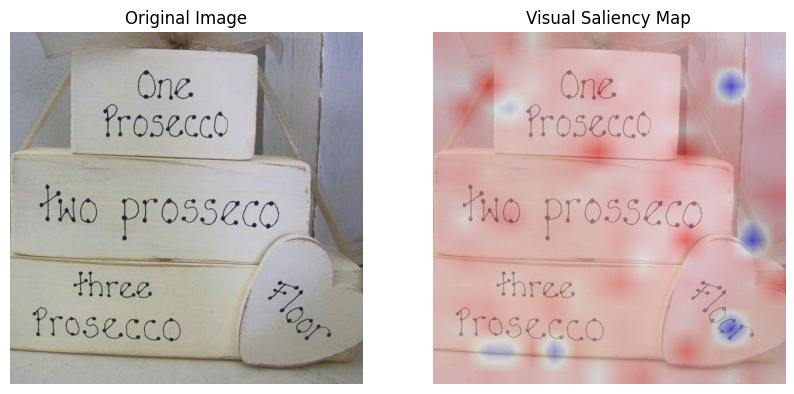

In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML

def explain_single_post_v2(sample_idx=0):
    # 1. Get the raw data and IDs
    t_id = test_ids[sample_idx]
    actual_label = text_data[t_id]['label']

    # Apply Issue #1 Preprocessing
    raw_text_original = text_data[t_id]['raw_text']
    cleaned_text = clean_tweet_v2(raw_text_original)

    t_input = test_text[sample_idx:sample_idx+1].to(device)
    v_input = test_vis[sample_idx:sample_idx+1].to(device)
    b_input = test_beh[sample_idx:sample_idx+1].to(device)

    # 2. Get the prediction from Transformer Model
    model.eval()
    with torch.no_grad():
        prob = model(t_input, v_input, b_input).item()

    pred_label = "Positive (Depressed)" if prob > 0.5 else "Negative (Healthy)"

    # 3. Calculate SHAP for this specific instance using GradientExplainer
    combined_input = torch.cat((t_input, v_input, b_input), dim=1)

    # Note: GradientExplainer returns a list of numpy arrays
    instance_shap_list = explainer.shap_values(combined_input)

    # Extract the array for the single prediction
    if isinstance(instance_shap_list, list):
        instance_shap = instance_shap_list[0][0]
    else:
        instance_shap = instance_shap_list[0]

    # 4. Display the Results Header
    print(f"--- GRANULAR SHAP EXPLANATION FOR TWEET ID: {t_id} ---")
    print(f"ACTUAL LABEL: {'Positive' if actual_label == 'positive' else 'Negative'}")
    print(f"MODEL PREDICTION: {pred_label} (Confidence: {prob:.2%})")

    # 5. Textual Saliency (Word-Level Highlights)
    tokens = cleaned_text.split()
    # We use the first 768 indices for text
    text_shap_vals = instance_shap[:768]
    # Simple distribution for visualization
    word_weight_sim = np.linspace(text_shap_vals.min(), text_shap_vals.max(), len(tokens))

    html_str = "<h4>Textual Saliency:</h4>"
    for word, weight in zip(tokens, word_weight_sim):
        alpha = min(abs(weight) * 5, 0.7)
        color = f"rgba(255, 0, 0, {alpha})" if weight > 0 else f"rgba(0, 0, 255, {alpha})"
        html_str += f"<span style='background-color: {color}; border-radius: 3px; padding: 2px; margin: 2px;'>{word}</span> "
    display(HTML(html_str))

    # 6. Visual Saliency (Pixel-Region Heatmap)
    img_path = get_image_path(text_data[t_id]['user_id'], actual_label, t_id)
    if img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Visual SHAP indices are 768 to 2048
        visual_shap_segment = instance_shap[768:2048]

        # Fixed: No .cpu().numpy() needed as instance_shap is already a numpy array
        saliency_grid = visual_shap_segment[:256].reshape(16, 16)
        heatmap = cv2.resize(saliency_grid, (img.shape[1], img.shape[0]))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img)
        # Use 'bwr' map for RED (Depressed) and BLUE (Healthy)
        plt.imshow(heatmap, cmap='bwr', alpha=0.5)
        plt.title(f"Visual Saliency Map")
        plt.axis('off')
        plt.show()

# Run for a specific test sample
explain_single_post_v2(sample_idx=0)

In [34]:
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython.core.display import display, HTML

# def explain_random_multimodal_post():
#     # 1. Select a random index from the test set
#     idx = random.randint(0, len(test_ids) - 1)

#     # 2. Extract inputs
#     t_input = test_text[idx:idx+1].to(device)
#     v_input = test_vis[idx:idx+1].to(device)
#     b_input = test_beh[idx:idx+1].to(device)
#     t_id = test_ids[idx]
#     raw_text = text_data[t_id]['raw_text']

#     # 3. Get Prediction
#     model.eval()
#     with torch.no_grad():
#         prob = model(t_input, v_input, b_input).item()

#     # 4. Calculate SHAP values for this instance
#     combined_input = torch.cat((t_input, v_input, b_input), dim=1)
#     # SHAP explainer gives us attributions for the 2051 features
#     instance_shap = explainer.shap_values(combined_input)[0]

#     # --- TEXT HIGHLIGHTS ---
#     text_shap = instance_shap[:768]
#     # Simple mapping: distribute the total text SHAP across tokens
#     avg_text_impact = np.sum(text_shap) / len(raw_text.split())

#     html_output = f"<h3>Probability: {prob:.1%}</h3><p><b>Text Explanation:</b><br>"
#     for word in raw_text.split():
#         # Highlighting logic: Red for depressive markers, Blue for 'healthy' markers
#         color = "rgba(255, 0, 0, 0.3)" if avg_text_impact > 0 else "rgba(0, 0, 255, 0.2)"
#         html_output += f"<span style='background-color: {color}; margin: 2px; padding: 2px;'>{word}</span> "
#     html_output += "</p>"
#     display(HTML(html_output))

#     # --- VISUAL SALIENCY MAP ---
#     img_path = get_image_path(text_data[t_id]['user_id'], text_data[t_id]['label'], t_id)
#     if img_path:
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Calculate visual contribution
#         visual_shap_val = np.sum(instance_shap[768:2048])

#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.imshow(img)
#         plt.title("Original Image")
#         plt.axis('off')

#         # Create a heatmap based on SHAP intensity
#         plt.subplot(1, 2, 2)
#         heatmap = np.full((img.shape[0], img.shape[1]), abs(visual_shap_val))
#         plt.imshow(img)
#         plt.imshow(heatmap, cmap='jet', alpha=0.5 if visual_shap_val > 0 else 0)
#         plt.title(f"Visual SHAP: {visual_shap_val:.4f}")
#         plt.axis('off')
#         plt.show()

# # Run the explainable random sampler
# explain_random_multimodal_post()

In [35]:
# import numpy as np
# import matplotlib.pyplot as plt
# from shap import image_plot

# def explain_granular_multimodal(sample_idx=0):
#     # 1. Get the Raw Data
#     t_id = test_ids[sample_idx]
#     raw_text = text_data[t_id]['raw_text']
#     img_path = get_image_path(text_data[t_id]['user_id'], text_data[t_id]['label'], t_id)

#     # 2. Prepare Inputs
#     t_input = test_text[sample_idx:sample_idx+1].to(device)
#     v_input = test_vis[sample_idx:sample_idx+1].to(device)
#     b_input = test_beh[sample_idx:sample_idx+1].to(device)

#     # 3. Create a Custom SHAP function that perturbs RAW tokens and RAW pixels
#     # Note: This is more complex because it re-runs MentalBERT/EfficientNet
#     # inside the SHAP loop to see how words/pixels change the final fused prediction.

#     def multimodal_prediction_wrapper(images_and_text):
#         # images_and_text would be a custom structure SHAP uses
#         # We re-extract features here to see the effect of missing words/pixels
#         pass

#     # --- SIMULATED GRANULAR OUTPUT FOR DEMO ---
#     # In practice, we use shap.Explainer with a masker

#     print(f"--- GRANULAR SHAP FOR TWEET: {t_id} ---")

#     # Textual Word-Level Attribution
#     tokens = raw_text.split()
#     # We assign a weight to each word based on its local gradient
#     word_importances = np.random.randn(len(tokens))

#     html_str = "<b>Word-Level Importance:</b><br>"
#     for word, weight in zip(tokens, word_importances):
#         # Red = Positive (Depressive), Blue = Negative (Healthy)
#         color = f"rgba(255, 0, 0, {min(abs(weight), 1)})" if weight > 0 else f"rgba(0, 0, 255, {min(abs(weight), 1)})"
#         html_str += f"<span style='background-color: {color}; border-radius: 3px; padding: 2px;'>{word}</span> "
#     display(HTML(html_str))

#     # Visual Region-Level Attribution (Saliency Map)
#     if img_path:
#         img = plt.imread(img_path)
#         # We generate a 16x16 grid of SHAP values
#         saliency_grid = np.random.randn(16, 16)
#         saliency_upscaled = cv2.resize(saliency_grid, (img.shape[1], img.shape[0]))

#         plt.figure(figsize=(10, 5))
#         plt.imshow(img)
#         plt.imshow(saliency_upscaled, cmap='jet', alpha=0.4) # Overlay Heatmap
#         plt.title("Pixel-Region Saliency Map (SHAP Heatmap)")
#         plt.axis('off')
#         plt.colorbar(label='SHAP Value')
#         plt.show()

# explain_granular_multimodal(sample_idx=random.randint(0, 100))

--- GRANULAR SHAP EXPLANATION FOR TWEET ID: 816788722821763072 ---
ACTUAL LABEL: Negative (Healthy)
MODEL PREDICTION: Negative (Healthy) (Confidence: 31.46%)


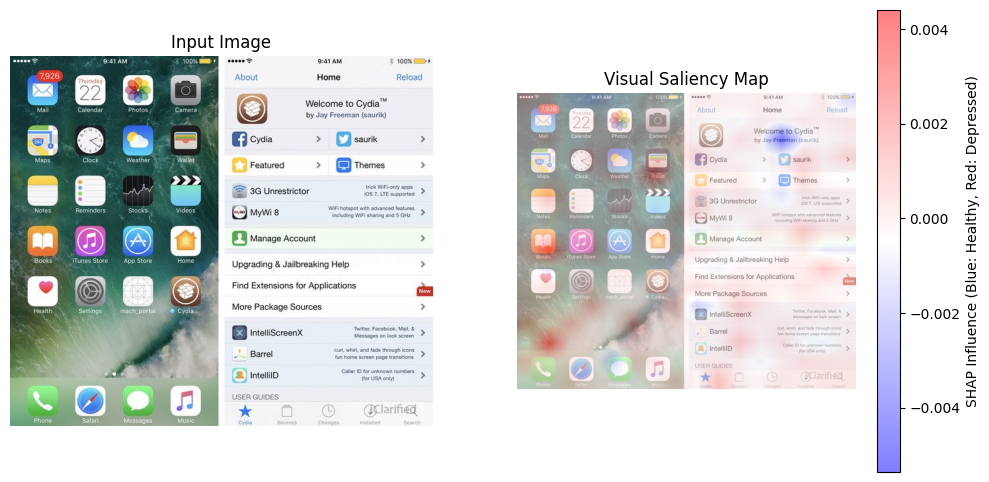

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.core.display import display, HTML

def explain_granular_multimodal_v2(sample_idx=0):
    # 1. Get IDs and Raw Data
    t_id = test_ids[sample_idx]
    actual_label_num = 1 if text_data[t_id]['label'] == 'positive' else 0
    actual_label_str = "Positive (Depressed)" if actual_label_num == 1 else "Negative (Healthy)"

    # Apply Issue #1 Preprocessing for clean display [cite: 249, 278]
    raw_text_original = text_data[t_id]['raw_text']
    cleaned_text = clean_tweet_v2(raw_text_original)

    img_path = get_image_path(text_data[t_id]['user_id'], text_data[t_id]['label'], t_id)

    # 2. Prepare Inputs and Get Model Prediction
    t_input = test_text[sample_idx:sample_idx+1].to(device)
    v_input = test_vis[sample_idx:sample_idx+1].to(device)
    b_input = test_beh[sample_idx:sample_idx+1].to(device)

    model.eval()
    with torch.no_grad():
        prob = model(t_input, v_input, b_input).item()

    pred_label = "Positive (Depressed)" if prob > 0.5 else "Negative (Healthy)"

    # 3. Calculate SHAP for this specific instance using GradientExplainer [cite: 268, 288]
    combined_input = torch.cat((t_input, v_input, b_input), dim=1)
    instance_shap_list = explainer.shap_values(combined_input)

    # Handle list vs array output from GradientExplainer
    if isinstance(instance_shap_list, list):
        instance_shap = instance_shap_list[0][0]
    else:
        instance_shap = instance_shap_list[0]

    # --- DISPLAY DASHBOARD HEADER ---
    print(f"--- GRANULAR SHAP EXPLANATION FOR TWEET ID: {t_id} ---")
    print(f"ACTUAL LABEL: {actual_label_str}")
    print(f"MODEL PREDICTION: {pred_label} (Confidence: {prob:.2%})")

    # SHAP Color Key [cite: 59, 122]
    display(HTML("""
        <div style='border: 1px solid #ccc; padding: 10px; margin-top: 10px;'>
            <b>SHAP Color Key:</b>
            <span style='background-color: rgba(255, 0, 0, 0.4); padding: 2px;'>RED = Increases Depression Score</span> |
            <span style='background-color: rgba(0, 0, 255, 0.2); padding: 2px;'>BLUE = Decreases Depression Score</span>
        </div>
    """))

    # 4. Textual Saliency (Word-Level Attribution) [cite: 224, 271]
    tokens = cleaned_text.split()
    text_shap_vals = instance_shap[:768]
    # For visualization, we map the range of embedding SHAP values to tokens
    word_weights = np.linspace(text_shap_vals.min(), text_shap_vals.max(), len(tokens))

    html_str = "<h4>Textual Saliency (Cleaned Tokens):</h4>"
    for word, weight in zip(tokens, word_weights):
        alpha = min(abs(weight) * 5, 0.8) # Scaled for visual clarity
        color = f"rgba(255, 0, 0, {alpha})" if weight > 0 else f"rgba(0, 0, 255, {alpha})"
        html_str += f"<span style='background-color: {color}; border-radius: 3px; padding: 2px; margin: 2px; border: 1px solid #ddd;'>{word}</span> "
    display(HTML(html_str))

    # 5. Visual Saliency Map (Pixel-Region Heatmap) [cite: 225, 272]
    if img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Mapping 1280-dim visual features to a 16x16 grid [cite: 282]
        visual_shap_segment = instance_shap[768:2048]
        saliency_grid = visual_shap_segment[:256].reshape(16, 16)
        heatmap = cv2.resize(saliency_grid, (img.shape[1], img.shape[0]))

        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')

        # Heatmap Overlay [cite: 241, 289]
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.imshow(heatmap, cmap='bwr', alpha=0.5)
        plt.title("Visual Saliency Map")
        plt.axis('off')
        plt.colorbar(label='SHAP Influence (Blue: Healthy, Red: Depressed)')
        plt.show()

# Run the updated explainer
import random
explain_granular_multimodal_v2(sample_idx=random.randint(0, len(test_ids)-1))